# 문제 정의
모기는 말라리아나 댕기와 같은 전염병을 전파할뿐만 아니라 생활에 매우 불편함을 주는 해충이다.
서울특별시에서는 이러한 모기로부터의 피해를 줄이는 행동방침의 기준을 제공하고자 모기예보제를 실시하고 있다.
수변부, 주거지, 공원에서 발생하는 모기 개체수와 기상 데이터를 산식에 넣어 도출된 지수를 통해 창문을 열어 환기를 할 것인지, 모기방지 약품을 살포할 것인지 등을 판단할 수 있다.
따라서 모기 지수를 예측하는 머신러닝모델을 만들어 적어도 집에서 모기를 보지 않도록 해보려 한다.

## 검증할 가설
- 수변부>공원>주거지 순으로 지수가 큰 것인가?
- 공원과 주거지의 모기지수는 연관이 있을까?

위와 같은 가설을 통해 지도학습을 시킬 Label로 어떤 지수를 채택하는 것이 좋을지 판단해볼 수 있다.
집에서 모기를 보고 싶지 않다면 주거지의 모기지수를 예측하는 것이 바람직할 것이기 때문이다.

사용자의 니즈에 따라 어떤 모기지수를 사용할 것인지 달라지겠지만, 이 모델을 만드는 내가 사용자라면 실내활동을 주로 하기 때문에 주거지에서의 모기지수가 더 유용했다. 수변부는 모기가 많이 태어나는 곳이기 때문에 야외활동이 많다면 공원, 실내활동이 많다면 주거지의 모기지수가 더 유용할 것이기 때문이다.

# 데이터 전처리하기
이 데이터는 서울특별시 시민건강국 감염병관리과에서 제공하는 모기예보제 정보를 서울열린데이터광장에서 API를 받아온 raw data이다.

이 CSV 파일은 json형식으로 되어있는 데이터를 csv파일로 변환한 것이다.

In [ ]:
import pandas as pd

raw_data = pd.read_csv('/content/drive/MyDrive/seoul_mosquito.csv', encoding='utf-8')
print(raw_data)

## 칼럼명 변경
한글로 칼럼명이 작성되어 있어 utf-8로 인코딩을 하였으나 여전히 칼럼명이 깨져있음을 확인할 수 있었다.

In [ ]:
raw_data.columns = ['date','mosquito_value_water','mosquito_value_house','mosquito_value_park']

## 중복값 제거
1970년 1월 1일이 무수히 중복되어 있고 2021년 10월 6일도 세 번 중복되어있음을 눈으로 확인할 수 있다.
같은 날짜의 데이터는 불필요하므로 날짜가 중복되는 데이터는 첫번째 값을 제외하고 제거하는 것이 적절하다 판단된다.

In [ ]:
raw_data = raw_data.drop_duplicates(['date'],keep='first')
raw_data

불필요한 1970-01-01의 데이터를 제거한다.

In [ ]:
raw_data = raw_data.drop([2077])
raw_data 

중복되는 값을 제외하니 해당 데이터는 2016년 5월 1일부터 관측되었다는 것을 알 수 있다.
### index 재설정하기

In [ ]:
raw_data = raw_data.reset_index(drop=True)
raw_data


## 결측치 처리

In [ ]:
raw_data.isna().sum()

In [ ]:
raw_data[raw_data['mosquito_value_water'].isnull()]

데이터의 수가 3000천개 미만으로 적은 편이며 위의 결측치의 발생 요인은 아래와 같다.
- 장마나 호우, 눈으로 인한 DNS에서 채집된 모기개체가 없다.
- 5~10월까지 모기를 채집하기 때문에 그 외의 월은 정확하지 않은 지수일 수 있다.

- 2018년 6월 19~22일의 데이터가 없는 이유는 호우로 인한 것일 수 있다.
- 기상청 날씨누리의 과거관측기록을 살펴본 결과 비는 오지 않았는데 누락되었다.
- 산식을 통해 2018년 6월 19~22일의 결측치를 채워줄 수 있다.

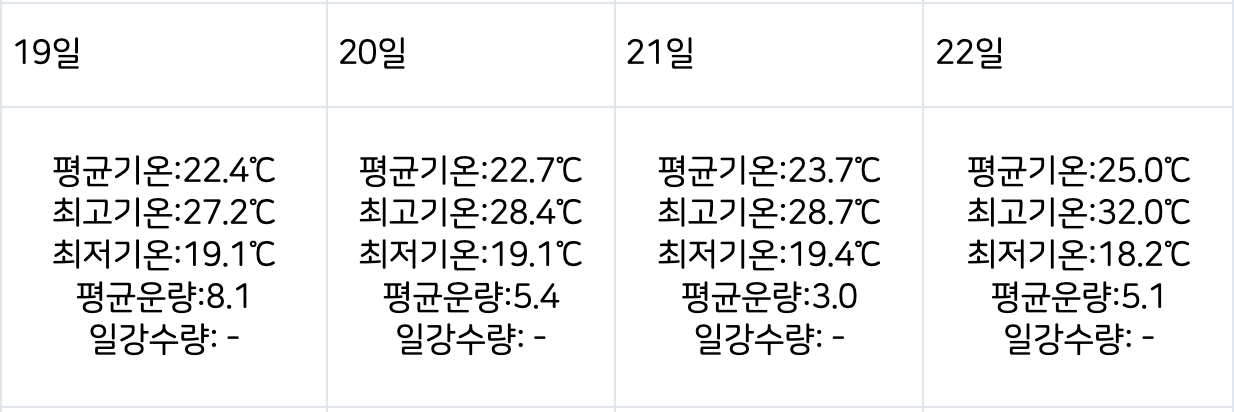

### 지역별 수치 계산법

- 수변부 = 최저기온*5.552 - 12.157
- 주거지 = 평균기온*3.346 - 최고기온*1.114+0.273
- 공원 = 최저기온* 3.290 + 최고기온*0.442- 강수량*0.082 - 21.349

In [ ]:
def water_value(min_temp):
  water_val = min_temp*5.552 - 12.157
  return round(water_val,1)

def house_value(avg_temp, max_temp):
  house_val = avg_temp*3.346-max_temp*1.114+0.273
  return round(house_val,1)

def park_value(min_temp,max_temp,precipitation):
  park_val = min_temp*3.290+max_temp*0.442-precipitation*0.082-21.349
  return round(park_val,1)

In [ ]:
water_value(19.1)
house_value(22.4,27.2)
park_value(19.1,27.2,0)

In [ ]:
#2018년 6월 19일
raw_data.loc[raw_data['date'] == '2018-06-19','mosquito_value_water'] = water_value(19.1)
raw_data.loc[raw_data['date'] == '2018-06-19','mosquito_value_house'] = house_value(22.4,27.2)
raw_data.loc[raw_data['date'] == '2018-06-19','mosquito_value_park'] = park_value(19.1,27.2,0)

#2018년 6월 20일
raw_data.loc[raw_data['date'] == '2018-06-20','mosquito_value_water'] = water_value(19.1)
raw_data.loc[raw_data['date'] == '2018-06-20','mosquito_value_house'] = house_value(22.7,28.4)
raw_data.loc[raw_data['date'] == '2018-06-20','mosquito_value_park'] = park_value(19.1,28.4,0)

#2018년 6월 21일
raw_data.loc[raw_data['date'] == '2018-06-21','mosquito_value_water'] = water_value(19.4)
raw_data.loc[raw_data['date'] == '2018-06-21','mosquito_value_house'] = house_value(23.7,28.7)
raw_data.loc[raw_data['date'] == '2018-06-21','mosquito_value_park'] = park_value(19.4,28.7,0)

#2018년 6월 22일
raw_data.loc[raw_data['date'] == '2018-06-22','mosquito_value_water'] = water_value(18.2)
raw_data.loc[raw_data['date'] == '2018-06-22','mosquito_value_house'] = house_value(25.0,32.0)
raw_data.loc[raw_data['date'] == '2018-06-22','mosquito_value_park'] = park_value(18.2,32.0,0)

2018년 6월 14일에는 15일까지 비가 내렸다.
따라서 두 날짜의 지수를 보고 결정할 수 있다.

In [ ]:
raw_data.loc[raw_data['date'] == '2018-06-15']

In [ ]:
raw_data.loc[raw_data['date'] == '2018-06-14','mosquito_value_water'] = 415.3
raw_data.loc[raw_data['date'] == '2018-06-14','mosquito_value_house'] = 415.3
raw_data.loc[raw_data['date'] == '2018-06-14','mosquito_value_park'] = 415.3

여기까지 와서야 다시 깨달았다.
수치 계산법이 2020년부터 달라졌다는 사실이다.
즉, 결측치들이 2020년 이전이기 때문에 큰 의미가 없다.



# 유의사항

- 2019년까지는 지리타입을 구분하지 않았기 때문에 위의 지리타입을 구분한 것은 2020년부터 유의미하다.
- 수변부 데이터가 100으로 고정되지 않은 행들을 위 수치가 나오게끔 최저기온과 평균기온으로 추정해줄 수 있다.
- 2020년부터는 모기 유충서식이 많거나 시민 생활과 밀접한 곳으로 구분하여 수변부, 공원, 주거지로 세분화하여 모기지수를 산출하기 때문에 2019년과 2020년 데이터의 편차가 있다.
- 서울시에 설치되어있는 모기 포집기기인 DMS가 5월 부터 10월까지 가동이 되기 때문에 본 산식에는 5월~10월 까지의 모기 포집 데이터와 기상 데이터가 사용된다.
- 11월~4월의 모기개체수와 환경요인의 데이터가 누적되지 않아, 산식에 반영되지 않기 때문에 해당 기간의 모기 개체수 예측 값은 정확도가 떨어질 수 있다.
- 산식은 기상데이터를 기반으로 산출되었기 때문에 겨울, 봄철 시기에 장기간동안 비가오지 않을 경우 경우 모기 예측값이 반복될 수 있다.
- 데이터 갱신 주기는 매일이다.

In [ ]:
#2019년까지의 데이터 제외하기

raw_data = raw_data[raw_data['date']>='2020-01-01']
raw_data

## 데이터 추가하기
2021-10-07
2021-10-08

In [ ]:
##append 사용하기
new_data = [{
    'date':'2021-10-07',
    'mosquito_value_water': 100.0,
    'mosquito_value_house': 50.1,
    'mosquito_value_park':61.7
}]

raw_data = raw_data.append(new_data, ignore_index=True)
raw_data

In [ ]:
raw_data = raw_data.sort_values(by=['date'])
raw_data = raw_data.reset_index(drop=True)
raw_data

겨울철  지수가 완전히 같은 부분은 모기개체수와 환경요인의 데이터가 누적되지 않아, 산식에 반영되지 않은 지점일 가능성이 크다. 제외하기보다 겨울철에 모기를 마주할 수 있다는 가능성을 보여준다는 점에서 내버려 두어도 좋을 것 같다.



## 모기지수 가설검정하기
- 수변부, 주거지, 공원의 모기지수는 같은 경향을 가지고 있는가?

In [ ]:
#모듈 불러오기
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(30,10))##캔버스 생성
ax = fig.add_subplot()##그림뼈대(프레임)생성

#그래프 만들어주기
ax.plot(raw_data['date'],raw_data['mosquito_value_water'],label='water')
ax.plot(raw_data['date'],raw_data['mosquito_value_park'],label='park')
ax.plot(raw_data['date'],raw_data['mosquito_value_house'],label='house')

plt.title('Status of Seoul Mosquitos')
ax.legend()
plt.show()

일단 위의 그래프를 보면 수변부 > 공원 > 주거지가 일반적인 것으로 보인다.
Ehgks 2020년과 2021년 지수의 전체적인 수치가 변경된 것으로 보아 산출식에서의 변화가 있거나 모기 개체수 전체가 줄어들었을 가능성이 있다. 해당 데이터의 햇수가 2개뿐이라 매우 부족하여 정확도가 낮을 것이다.

공원의 모기지수는 주거지의 모기지수보다 높을 것이다를 검정해본다.

- H0 : 공원 모기지수는 주거지 모기지수보다 크지 않을 것이다.
- H1 : 공원 모기지수는 주거지 모기지수보다 클 것이다.

유의수준 95%로 t-test의 단측 대립가설로 검증할 수 있을 것이다.
두 집단이 같은지 다른지 비교하면서 두 집단의 평균값이 통계적으로 같은지 다른지 확인할 수 있기 때문이다. 두 집단을 비교하는 것이므로 두 그룹의 분산이 동일하다는 가설을 검정한 뒤에 독립표변 t 검정(two-sample-t-test)를 시행해 보았다.


In [ ]:
from scipy import stats
levene = stats.levene(raw_data['mosquito_value_park'],raw_data['mosquito_value_house'])
print('LeveneResult(statistic = %.3f, p-value = %.3f)'% levene)

p-value가 통상적인 기준인 0.1보다 작기 때문에 두 그룹의 분산이 동일하다는 가정을 받아들일 수 없다.


이로인해 t 검정을 할 수 없고 집단이 3개 이상인다른 데이터를 비교할 수 있는 ANOVA 분석도 할 수 없다. 집단이 전혀 다른 두 모기 지수를 비교하려면 두 집단 각각에서 추정된 분산이 동일하지 않을 때 쓰이는 Welch's T-test를 사용해 두 집단 차이를 볼 수 있겠지만 6일 정도 안에 마쳐야하는 프로젝트이므로 해당 t-test를 실시하지 않고 실내 활동이 많은 작성자의 기준에서 유용한 모기지수인 주거지 모기지수를 바탕으로 머신러닝모델을 수립하고자 한다.

## feature engineering
위의 지수들이 최저기온, 평균기온, 최고기온, 강수량을 바탕으로 만들어져있다는 점에서  4가지 feature를 간단한 수식으로 도출할 수 있다. 비록 데이터의 수가 너무 적어서 과적합의 위험이 있지만 특정 지수를 label로 하는 머신러닝 모델을 구축할 수 있을 것이라 기대했다.

하지만 주어진 수식으로는 최저기온, 평균기온, 최고기온, 강수량을 구할 수 없었다. 연립방정식을 사용하려고 해도 주어진 계산식과 미지수가 이상하기 때문에.... 이 자료를 위해 2020년 1월 1일부터 2021년 10월 8일까지의 최저, 최고, 평균 기온을 기상청에서 csv파일 형식으로 받아와 붙여주는 방식으로 feature를 구할 수 있을 것이다.

In [ ]:
#df['min_temp'] = round((df['mosquito_value_water']-12.157)/5.552,1)
#위의 수식처럼 지수를 통해 최저기온까지는구할 수 있으나 이 최저기온의 경우 해당 측정소에서 추출한 것이기 때문에 정확하지 않으며 한계가 뚜렷하므로 사용하지 않고
#기상청의 데이터를 불러와 유의미한 feature들을 추가해주는 것이 바람직하다 판단된다.

# 기상데이터 가져와서 더해주기

In [ ]:
#string to datetime
if 'date' in raw_data.columns:
  raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.info()

In [ ]:
raw_data

## 기온 데이터 pull한 뒤 전처리
출처: 기상청 기상자료개방포털 기후통계분석

In [ ]:
temp_df = pd.read_csv('/content/drive/MyDrive/forcast_data.csv', encoding='utf-8')
temp_df

In [ ]:
#검색조건 열을 지워주고 index1번을 column으로 바꿔주기
temp_df = temp_df.drop(labels=0)
temp_df = temp_df.rename(columns=temp_df.iloc[0]).drop(labels=1).reset_index(drop=True)

#칼럼명을 영어로 바꿔주기
temp_df.columns = ['date','avg_temp','min_temp','max_temp']
#temp_df = temp_df.drop(labels='date',axis=1)
temp_df

## 강수량 데이터 pull한 뒤 전처리
출처: 기상청 기상자료개방포털 기후통계분석

In [ ]:
rain_df = pd.read_csv('/content/drive/MyDrive/rain.csv')
rain_df.columns=['date','precipitation']

결측치는 비가 오지 않은 날, 0.0으로 표기된 값은 반올림값이 0.0으로 버려진 것으로 예상된다.
0.0값이 원래 어떤 값인지 정보가 없으므로 비가 오지 않은 것으로 가정하고 비가 오지 않은 날과 비가 오긴 왔으나 미약한 것을 모두 0.0으로 통일시켜주었다.

In [ ]:
rain_df = rain_df.fillna(0.0)
rain_df

## 각 데이터들을 하나의 데이터프레임으로 합쳐주기

1. 기온과 강수량 하나로 합쳐주기

In [ ]:
weather_df = pd.merge(temp_df,rain_df)
weather_df = weather_df.drop(labels='date', axis=1)
weather_df

2. 모기지수 데이터와 날씨 정보 데이터를 하나로 합쳐주기

In [ ]:
df = pd.concat([raw_data,weather_df],axis=1)
df

In [ ]:
#column 순서 바꿔주기
df = df[['date','avg_temp','min_temp','max_temp','precipitation','mosquito_value_water','mosquito_value_park','mosquito_value_house']]

#집단이 각각 다른 집단인 수변부, 주거지, 공원 중, 해결하고자 하는 문제(실내 모기지수 예측)와 가장 밀접하게 연관된 주거지의 모기지수를 label로 하고 나머지 모기지수를 제외한다.
df = df.drop(labels=['mosquito_value_water','mosquito_value_park'],axis=1)
df

## 시계열 데이터 요소 추출 (trend, seasonal, residual)


### seaonal decompose

statsmodels.api(sm)을 이용해서 sm.tsa.seasonal_decompose를 사용하면 데이터값을 trend(경향), seasonal(주기성), residual(잔차)로 분리할 수 있다고 한다. 이에 대해서는 추가적인 학습이 필요하나 시간적 여유가 불충분하므로 학습 모델을 선정한 뒤 적절한 시간순서에 따라 훈련데이터와 테스트데이터를 잘 나누어 모델을 만들어주는 것이 프로젝트를 완료하는 데에 더 적합할 것이라 판단한다.

시간열 데이터를 분석하고 추출하는 것은 차후 프로젝트를 진행하면서 학습을 할 것이다.

# EDA

In [ ]:
df.dtypes

In [ ]:
#기온데이터를 float형으로 바꿔주기
df['avg_temp'] = pd.to_numeric(df['avg_temp'])
df['max_temp'] = pd.to_numeric(df['max_temp'])
df['min_temp'] = pd.to_numeric(df['min_temp'])

df.dtypes

In [ ]:
df.describe()

## 이상치 판단하기
수치가 100이상인 부분들이 이상치인지 확인해볼 필요가 있을 것이다.
위의 수치들 중 이상치라고 판단할 수 있는 지점은 이상기후 정도로 보인다.
동아일보에 따르면 2020년은 1년 내내 이상기후였으며 연이은 태풍발생 및 집중호우로 인하여 통상적인 기상이라고 하기 어려우며 2021년은 세계 최고 기온이 경신된 날이다. 지구온난화 등의 환경문제로 인해 지표들 전체가 이상치라고도 볼 수 있을 것이다.

전세계적인 기후이상은 한국도 예외가 아니기 때문에 위의 지수들이 정상적이라고 보긴 어려울 것이다.
그럼에도 불구하고 앞으로 동일한 산식으로 지표가 누적됨과 동시에 기후데이터가 쌓인다면 연이은 이상기후에서도 보다 정확한 모기지수를 예측할  수 있을 것이라 예상된다.

따라서 위의 데이터를 통해 기후환경에 대한 해박한 도메인 지식이 없으므로 정확성에 대해서는 유의를 하며 해당 데이터를 통해 머신러닝모델을 만들어보고자한다.

## 중복값 판단하기

많은 머신러닝의 경우, 중복값을 포함한 채 머신러닝 모델을 만들게 되면 가중치가 붙을 수 있다.
데이터의 품질을 높히는 것이 적은 데이터로도 좋은 성능을 만들어주는 데에 좋을 것이라 판단된다.

In [ ]:
#df의 칼럼 'date' 때문에 중복되는 값이 없는 것으로 보인다.
#df에서 'date' 칼럼이 없는 데이터프레임을 통해 없애줘보자.
df.duplicated().sum()

In [ ]:
#위 데이터는 시계열데이터로도 만들어줄 수 있을 것이다.
#시계열데이터가 이 분석에 유의미할까?
#모기는 일반적으로 여름에 주로 많이 관찰된다는 점에서 시계열데이터가 유의미할 것이다.

# 시간열데이터로 만들어서 보기

In [ ]:
df_t = df.copy()
df_t = df_t.set_index('date')
df_t

In [ ]:
df_t.duplicated().sum()

In [ ]:
df['mosquito_value_house'].duplicated().sum()

600여개 중에 절반이 중복값이다. 
중복된 값은 데이터 제공측에서 겨울, 봄철 시기에 장기간동안 비가 오지 않았을 경우에 반복된다고 한다.
해당 시기에 비가 오지않아 모기가 출현할 확률이 지극히 낮은 것으로 보인다. 모기개체수를 채집하지 않는 시기에 중복된 값이 집중적으로 나왔으며 2020년의 지수가 동일한 구간이 있는데 2021년에는 그러한 구간이 없는 것으로 보아 2020년과 2021년의 측정 방식이 달라졌다고 판단된다. 다행히 기상데이터는 온전히 같은 데이터가 드물며 위의 데이터의 수가 적다는 점에서 중복되는 값이 있다할지라도 포함해야할 것이며 산식이 변경되어 데이터가 변경되거나 시간이 충분히 흐른 뒤에 충분한 데이터가 생기면 더 정확도가 높은 머신러닝모델을 만들 수 있을 것이다.

### csv, json 파일로 저장하기

In [ ]:
df_t.to_json('seoul_mosquito_status.json')

In [ ]:
df_t.to_csv('seoul_mosquito_status_t.csv')

# 모델 검증법 및 데이터셋 분할 방법 

시계열데이터는 시간의 순서에 따라 훈련데이터와 테스트 데이터를 나누어야한다.
전체 데이터의 80%는 516개인데, 모기가 2021년에도 왕성하게 활동한 것으로 예상되는 지점이자 1년 반 이상의 시간의 순서가 담긴 일자인, 인덱스 기준 549번인 7월 4일을 선정했다. 

홀수/짝수로 구분해서 검증하는 것은 어떠할지 개인적인 의문이 들었다.


In [ ]:
train = df_t.loc[df_t.index<'2021-07-04',:]
test = df_t.loc[df_t.index>='2021-07-04',:]

In [ ]:
#타겟과 특성 분리하기
target = 'mosquito_value_house'
features = df_t.drop(columns=[target]).columns

In [ ]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 기준모델
한국은 각 계절별로 온도차와 강수량 차이가 심하며 이 데이터는 시계열 데이터이기 때문에 이전 타임스탬프의 값이 기준모델이 될 것이다. 그러나 현재 타임스탬프의 값으로 모델의 성능을 검증하는 것을 온전히 이해하지 못했으므로 시간열 데이터 예측에 자주 쓰이는 모델들을 구현하여 가장 오차가 적은 모델을 채택하고자 한다.

## OLS
Ordinary Least Square이라는 모델로 간단한 회귀분석이다.
가장 기본적인 결정론적 선형 회귀 방법으로 RSS를 최소화하는 가중치 벡터를 행렬미분으로 구하는 방법이다.

In [ ]:
#from statsmodels.formula.api import ols
#ols_model = ols(formula = 'mosquito_value_house ~ avg_temp+min_temp+max_temp+precipitation', data=train).fit()
#print(ols_model.summary())
#위의 방식으로 모델을 만들면 str으로 되어있는 값들을 웹에서 입력된 값들이 인식을 못하는 것으로 보인다.
#터미널에서 받은 오류: Error evaluating factor: IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
#mosquito_value_house ~ avg_temp+min_temp+max_temp+precipitation

import statsmodels.api as sm

ols_model = sm.OLS(y_train,X_train)
ols_model = ols_model.fit()
ols_model.params

In [ ]:
ols_model.summary()

### 결과해석

R-squared값은 1에 가까울수록 좋고, F-statics는 F통계량으로 도출되 회귀식이 적절한지 볼 수 있는 것으로 0에 가까울수록 좋다. p값들은 0.05보다 작아야 유의미하다고 할 수 있는데 평균기온의 p값이 0.05보다 크기 때문에 통계적으로 유의하다고 하기 어렵다. R2값이 0.05라는 점에서 이 모델은 정말 성능이 좋지 않다고 할 수 있다.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = ols_model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
pred_r2 = r2_score(y_train, y_pred)

print(f'훈련 에러(MAE):{mae}')
print(f'훈련 에러(MSE):{mse}')
print(f'훈련 에러(R2):{pred_r2}')

y_pred = ols_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pred_r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(MSE):{mse}')
print(f'테스트 에러(R2):{pred_r2}')

## 릿지 회귀

In [ ]:
##릿지 회귀모델의 하이퍼파라미터 튜닝하기
from sklearn.linear_model import RidgeCV, Ridge

alphas = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.1, 0.15, 0.5, 1.0, 10.0, 100.0]

ridge = RidgeCV(alphas = alphas,
                normalize=True,
                cv=3)

ridge.fit(X_train, y_train)
print('alpha: ',ridge.alpha_)

In [ ]:
ridge_model = Ridge(alpha=0.007, normalize=True)
ridge_model.fit(X_train,y_train)
y_pred = ridge_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(R2):{pred_r2}')

### 결과해석
R2값은 거의 비슷하지만 MAE값이 릿지회귀가 더 작다.
아예 다른 모델을 선정해야한다.

## lightgbm



In [ ]:
import lightgbm as lgb

train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test)

In [ ]:
params = {'learning_rate': 0.01, 
          'max_depth': 10,
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [ ]:
lgbm_model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

In [ ]:
predict_train = lgbm_model.predict(X_train)
predict_test = lgbm_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)

## 결과해석

앞선 두 모델보다 r2값이 월등하게 높다.
Lightgbm을 사용한 모델을 채택하려했으나 lightgbm이 가상환경에서 작동하지 않아 시간관계상 다른 모델을 사용하기로 했다.

## multiple regression

In [ ]:
from sklearn.linear_model import LinearRegression
multi_model = LinearRegression()

#모델 훈련
multi_model.fit(X_train, y_train)

#예측값 도출
y_pred = multi_model.predict(X_test)

#평가지표
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(R2):{pred_r2}')

# 시계열 데이터처럼 취급하지 않고 모델을 만든다면?

In [ ]:
from sklearn.model_selection import train_test_split

train, test= train_test_split(df_t, random_state=42)
train.shape, test.shape

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
#릿지 회귀
ridge_model = Ridge(alpha=0.007, normalize=True)
ridge_model.fit(X_train,y_train)
y_pred = ridge_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(R2):{pred_r2}')

In [ ]:
#OLS
ols_model = sm.OLS(y_train,X_train)
ols_model = ols_model.fit()

y_pred = ols_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pred_r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(MSE):{mse}')
print(f'테스트 에러(R2):{pred_r2}')

In [ ]:
#다중선형회귀
multi_model.fit(X_train, y_train)

#예측값 도출
y_pred = multi_model.predict(X_test)

#평가지표
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'테스트 에러(MAE):{mae}')
print(f'테스트 에러(R2):{pred_r2}')

# 모델 선택: 다중선형회귀

시계열 데이터로 취급하지 않고 예측을 해본 결과 다중선형회귀와 OLS가 R2값이 0.75 정도로 가장 높으며 유사하나 MAE값이 다중선형회귀가 더 작으므로 이 모델의 유의미함을 위하여 다중선형회귀 모델을 채택하고자 한다.

만들고자 하는 서비스가 시간의 흐름에 영향을 많이 받지만 기후 수치를 입력할 때 대략적인 수치를 신뢰할 수 있을만한 수준으로 예측하기 위해서 시계열 데이터를 예측하기 위한 공부를 한 뒤에 경향성을 포함하면 더 신뢰할 수 있는 결과를 만들 것이다. 

# 모델을 pickle로 저장하기

기계학습을 한 뒤 모델을 저장하기 위해 사용하는 방법 중 하나인 pickle을 사용하여 모델을 저장하고자 한다. 이 외에도 joblib을 사용하는 방법도 있다.

In [ ]:
import pickle

with open('model_211007.pickle','wb') as fw:
  pickle.dump(multi_model,fw)